In [59]:
import nibabel as nib
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Import Residual MLP model
from models.residual_mlp import ResidualMLPRegressor

In [60]:
# Load the Patient05 NIfTI file
Patient5_img = nib.load(r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_mc_normb0.nii.gz')
Patient5_data = Patient5_img.get_fdata()
print("=== Loading Patient5_data ===")
print(f"Loaded brain data shape: {Patient5_data.shape}")
print(f"Data type: {Patient5_data.dtype}")

=== Loading Patient5_data ===
Loaded brain data shape: (112, 112, 60, 153)
Data type: float64


In [61]:
# Load the NLLS fitted parameters from MATLAB file
import scipy.io as sio

Patient5_NLLS_mat = sio.loadmat(r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\FittedParams_AstroSticksdvZeppelinSphereB0T2_FWE_fixdv_40.mat')
print("=== Loading NLLS fitted parameters ===")
print(f"Available keys in MATLAB file: {list(Patient5_NLLS_mat.keys())}")

# Filter out MATLAB metadata keys
data_keys = [key for key in Patient5_NLLS_mat.keys() if not key.startswith('__')]
print(f"Data keys: {data_keys}")

=== Loading NLLS fitted parameters ===
Available keys in MATLAB file: ['__header__', '__version__', '__globals__', 'model', 'gsps', 'mlps', 'fobj_gs', 'fobj_ml', 'error_code']
Data keys: ['model', 'gsps', 'mlps', 'fobj_gs', 'fobj_ml', 'error_code']


In [62]:
# Extract parameter structure
model = Patient5_NLLS_mat['model']
gsps = Patient5_NLLS_mat['gsps']
mlps = Patient5_NLLS_mat['mlps']

print(f"NLLS data loaded - Model parameters shape: {mlps.shape}")
print(f"Grid search parameters shape: {gsps.shape}")

NLLS data loaded - Model parameters shape: (50501, 12)
Grid search parameters shape: (50501, 12)


In [63]:
# Extract parameter names and target parameters
param_names = [param[0] for param in model[0][0][2][0]]
target_params = ['ficvf', 'fee', 'di', 'rads']  # ficvf=fic, fee=fee, di=Dic, rads=R

# Extract the specific parameters from mlps
fic_values = mlps[:, 0]   # ficvf
fee_values = mlps[:, 1]   # fee  
Dic_values = mlps[:, 4]   # di (diffusivity intracellular)
R_values = mlps[:, 3]     # rads (radius)

print("Extracted NLLS parameters: fic, fee, Dic, R")

Extracted NLLS parameters: fic, fee, Dic, R


In [64]:
# Unit Conversions to SI
# Convert Dic from μm²/ms to m²/s: 1 μm²/ms = 1e-9 m²/s
Dic_values = Dic_values * 1e-9  

# Convert R from μm to m: 1 μm = 1e-6 m
R_values = R_values * 1e-6  

print("Units converted: Dic to m²/s, R to m")

Units converted: Dic to m²/s, R to m


In [65]:
# Basic parameter statistics
parameters = {
    'fic': fic_values,
    'fee': fee_values, 
    'Dic': Dic_values,  # in m²/s
    'R': R_values      # in m
}

print("=== NLLS Parameter Statistics ===")
print("Parameter | Mean        | Std         | Min         | Max         | Zeros")
print("----------|-------------|-------------|-------------|-------------|-------")

for param_name, param_values in parameters.items():
    mean_val = np.mean(param_values)
    std_val = np.std(param_values)
    min_val = np.min(param_values)
    max_val = np.max(param_values)
    zero_count = np.sum(param_values == 0)
    
    # Use scientific notation for very small values (Dic and R)
    if param_name in ['Dic', 'R']:
        print(f"{param_name:9s} | {mean_val:11.2e} | {std_val:11.2e} | {min_val:11.2e} | {max_val:11.2e} | {zero_count:7d}")
    else:
        print(f"{param_name:9s} | {mean_val:11.4f} | {std_val:11.4f} | {min_val:11.4f} | {max_val:11.4f} | {zero_count:7d}")

print(f"\nTotal voxels: {len(fic_values)}")
print("Note: Dic values are in m²/s, R values are in m")

=== NLLS Parameter Statistics ===
Parameter | Mean        | Std         | Min         | Max         | Zeros
----------|-------------|-------------|-------------|-------------|-------
fic       |      0.1073 |      0.1737 |      0.0000 |      1.0000 |    5873
fee       |      0.7961 |      0.2149 |      0.0000 |      1.0000 |    1061
Dic       |    1.10e-09 |    4.67e-10 |    1.00e-11 |    3.00e-09 |       0
R         |    8.56e-06 |    7.08e-06 |    1.00e-06 |    2.00e-05 |       0

Total voxels: 50501
Note: Dic values are in m²/s, R values are in m


In [66]:
# Create final results DataFrame
results_df = pd.DataFrame({
    'fic': fic_values,
    'fee': fee_values,
    'Dic': Dic_values,  # in m²/s
    'R': R_values       # in m
})

print(f"NLLS Results DataFrame created with shape: {results_df.shape}")
print(f"Parameters: fic (intracellular fraction), fee (extracellular fraction)")
print(f"           Dic (intracellular diffusivity, m²/s), R (cell radius, m)")
print(f"\nData ready for model training and evaluation.")

NLLS Results DataFrame created with shape: (50501, 4)
Parameters: fic (intracellular fraction), fee (extracellular fraction)
           Dic (intracellular diffusivity, m²/s), R (cell radius, m)

Data ready for model training and evaluation.


CREATING NLLS PARAMETER MAP VISUALIZATION FOR TUMOR REGIONS
=== Data Dimension Analysis ===
Brain data shape: (112, 112, 60, 153)
ROI data shape: (112, 112, 60)
NLLS parameter array length: 50501
Total tumor voxels (ROI 1+2): 6204
NLLS fitted voxels: 50501
Tumor voxels in central slice 30: 313
Mapping 313 NLLS parameters to central slice tumor voxels


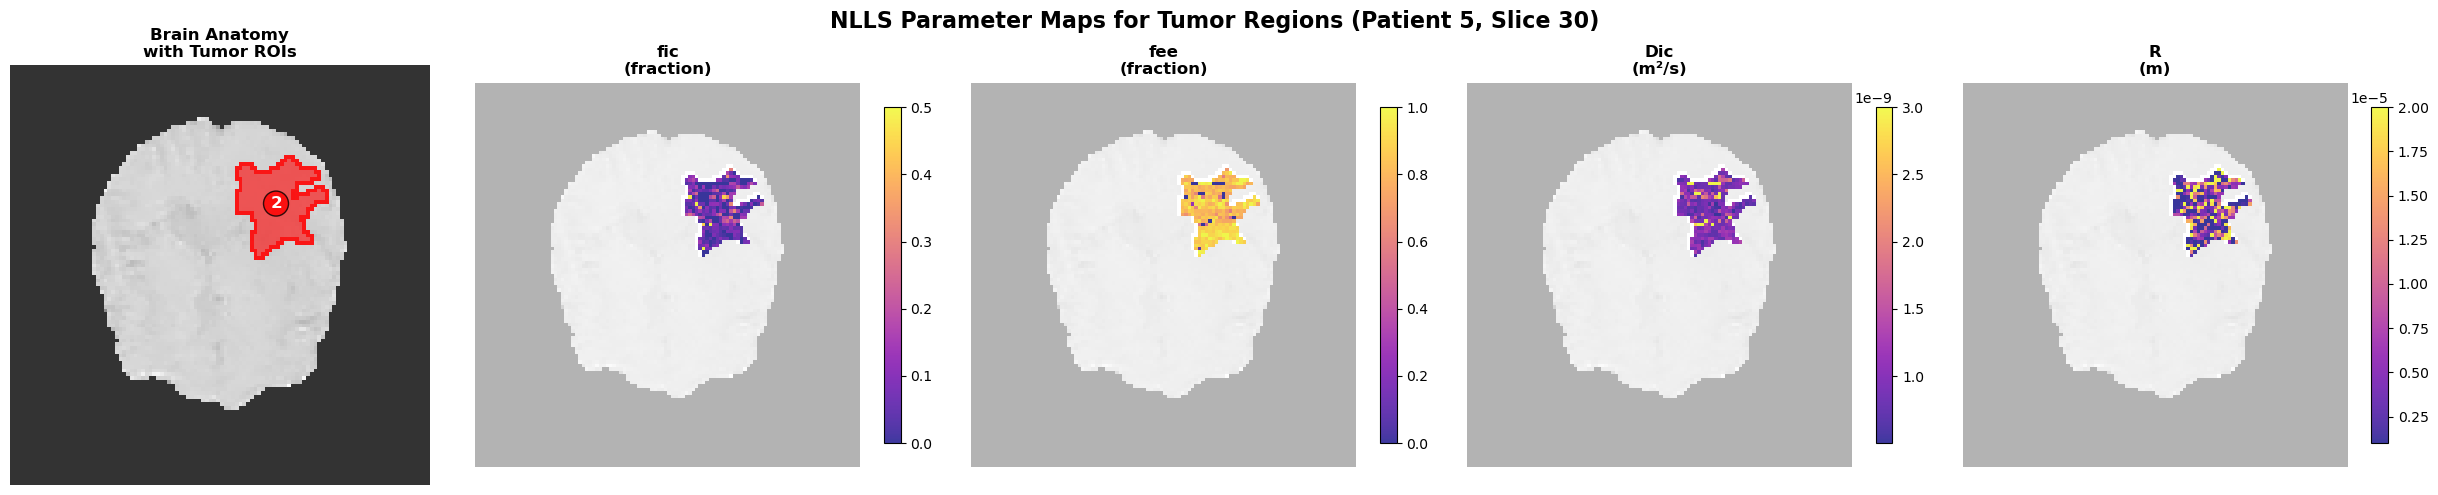


NLLS Parameter Statistics for Tumor Regions in Central Slice 30:
fic:  313 voxels | Mean=  0.0826 ±   0.1033 | Range=[  0.0000,   0.9083]
fee:  313 voxels | Mean=  0.8093 ±   0.2037 | Range=[  0.0000,   1.0000]
Dic:  313 voxels | Mean=1.10e-09 ± 5.33e-10 | Range=[4.11e-10, 3.00e-09]
R  :  313 voxels | Mean=7.49e-06 ± 6.88e-06 | Range=[1.00e-06, 2.00e-05]

Complete NLLS Tumor Analysis Summary:
• Total tumor voxels in volume: 6,204
• NLLS fitted voxels: 50,501
• Coverage: 814.0% of tumor voxels
• Central slice tumor voxels: 313

Overall NLLS Parameter Ranges (All 50,501 tumor voxels):
  fic: Mean=  0.1214, Range=[  0.0000,   1.0000]
  fee: Mean=  0.8132, Range=[  0.0000,   1.0000]
  Dic: Mean=1.10e-09, Range=[1.00e-11, 3.00e-09]
  R: Mean=8.56e-06, Range=[1.00e-06, 2.00e-05]

NLLS tumor parameter visualization completed.


In [67]:
# NLLS PARAMETER MAP VISUALIZATION FOR TUMOR REGIONS
print("CREATING NLLS PARAMETER MAP VISUALIZATION FOR TUMOR REGIONS")
print("=" * 80)

import pandas as pd
from scipy import ndimage
from matplotlib.colors import ListedColormap

# Load ROI data if not already loaded
try:
    Patient5_roi_data
except NameError:
    Patient5_roi_path = r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_ROIs_to_DWI_small.nii.gz'
    Patient5_roi_img = nib.load(Patient5_roi_path)
    Patient5_roi_data = Patient5_roi_img.get_fdata()
    print("Loaded ROI data")

# Debug: Check data dimensions
print("=== Data Dimension Analysis ===")
print(f"Brain data shape: {Patient5_data.shape}")
print(f"ROI data shape: {Patient5_roi_data.shape}")
print(f"NLLS parameter array length: {len(fic_values)}")

# Find tumor voxels (ROI values 1 and 2)
tumor_mask_3d = (Patient5_roi_data == 1) | (Patient5_roi_data == 2)
tumor_voxel_count = np.sum(tumor_mask_3d)
print(f"Total tumor voxels (ROI 1+2): {tumor_voxel_count}")
print(f"NLLS fitted voxels: {len(fic_values)}")

# Get central slice
central_slice = Patient5_data.shape[2] // 2
brain_slice = Patient5_data[:, :, central_slice, 0].T

# Enhance brain contrast
brain_norm = (brain_slice - brain_slice.min()) / (brain_slice.max() - brain_slice.min() + 1e-8)
brain_enhanced = np.power(brain_norm, 0.6)

# Create parameter maps by mapping NLLS results back to tumor regions
H, W, D = Patient5_data.shape[:3]
nlls_param_maps = {}
compare_params = ['fic', 'fee', 'Dic', 'R']

# Initialize parameter maps with NaN
for param_name in compare_params:
    nlls_param_maps[param_name] = np.full((H, W), np.nan)

# Map NLLS parameters to tumor voxels in the central slice
tumor_slice_mask = tumor_mask_3d[:, :, central_slice].T
tumor_coords_slice = np.where(tumor_slice_mask)

if len(tumor_coords_slice[0]) > 0:
    print(f"Tumor voxels in central slice {central_slice}: {len(tumor_coords_slice[0])}")
    
    # Get 3D coordinates of all tumor voxels
    tumor_coords_3d = np.where(tumor_mask_3d)
    
    # Find which tumor voxels are in the central slice
    slice_indices = tumor_coords_3d[2] == central_slice
    n_slice_voxels = np.sum(slice_indices)
    
    if n_slice_voxels > 0 and n_slice_voxels <= len(fic_values):
        print(f"Mapping {n_slice_voxels} NLLS parameters to central slice tumor voxels")
        
        # Get the first n_slice_voxels from NLLS results (assuming same order)
        for i, param_name in enumerate(compare_params):
            param_data = parameters[param_name][:n_slice_voxels]
            
            # Map to slice coordinates
            y_coords = tumor_coords_slice[0][:n_slice_voxels]
            x_coords = tumor_coords_slice[1][:n_slice_voxels]
            
            for j in range(n_slice_voxels):
                nlls_param_maps[param_name][y_coords[j], x_coords[j]] = param_data[j]

# Get tumor regions for overlay
roi_slice = Patient5_roi_data[:, :, central_slice].T
tumor_regions = {}
for roi_val in [1, 2]:
    tumor_mask = roi_slice == roi_val
    if np.any(tumor_mask):
        tumor_regions[f'Tumor_{roi_val}'] = tumor_mask

# Create visualization with proper parameter maps
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle(f'NLLS Parameter Maps for Tumor Regions (Patient 5, Slice {central_slice})', 
             fontsize=16, fontweight='bold')

# Brain anatomy with tumor overlay (first subplot)
ax = axes[0]
ax.imshow(brain_enhanced, cmap='gray', vmin=0, vmax=1, alpha=0.8)

# Overlay tumor regions
tumor_colors = ['red', 'orange']
for i, (tumor_name, tumor_mask) in enumerate(tumor_regions.items()):
    if np.any(tumor_mask):
        # Create tumor boundary
        dilated = ndimage.binary_dilation(tumor_mask, structure=np.ones((3,3)))
        boundary = dilated & ~tumor_mask
        
        # Show tumor region
        tumor_overlay = np.ma.masked_where(~tumor_mask, tumor_mask)
        boundary_overlay = np.ma.masked_where(~boundary, boundary)
        
        ax.imshow(tumor_overlay, cmap=ListedColormap([tumor_colors[i]]), 
                 alpha=0.6, vmin=0, vmax=1)
        ax.imshow(boundary_overlay, cmap=ListedColormap([tumor_colors[i]]), 
                 alpha=0.9, vmin=0, vmax=1)
        
        # Add tumor labels
        coords = np.where(tumor_mask)
        if len(coords[0]) > 0:
            centroid_y, centroid_x = coords[0].mean(), coords[1].mean()
            ax.text(centroid_x, centroid_y, tumor_name.split('_')[1], 
                   color='white', fontsize=12, fontweight='bold', 
                   ha='center', va='center',
                   bbox=dict(boxstyle='circle', facecolor=tumor_colors[i], alpha=0.8))

ax.set_title('Brain Anatomy\nwith Tumor ROIs', fontweight='bold')
ax.axis('off')

# Parameter maps (remaining subplots)
for j, param_name in enumerate(compare_params):
    ax = axes[j + 1]
    
    # Show brain anatomy as background
    ax.imshow(brain_enhanced, cmap='gray', alpha=0.3, vmin=0, vmax=1)
    
    # Overlay parameter map
    param_map = nlls_param_maps[param_name]
    
    # Set color range based on valid values
    valid_values = param_map[~np.isnan(param_map)]
    if len(valid_values) > 0:
        if param_name == 'fic':
            vmin, vmax = 0, 0.5  # Constrain fic to maximum of 0.5
        elif param_name == 'fee':
            vmin, vmax = 0, 1
        else:  # Dic, R
            vmin, vmax = np.percentile(valid_values, [1, 99])
        
        # Create masked array to hide NaN values
        param_masked = np.ma.masked_where(np.isnan(param_map), param_map)
        
        im = ax.imshow(param_masked, cmap='plasma', alpha=0.8, vmin=vmin, vmax=vmax)
        
        # Add tumor boundaries
        for tumor_name, tumor_mask in tumor_regions.items():
            if np.any(tumor_mask):
                boundary = ndimage.binary_dilation(tumor_mask, structure=np.ones((2,2))) & ~tumor_mask
                boundary_overlay = np.ma.masked_where(~boundary, boundary)
                ax.imshow(boundary_overlay, cmap=ListedColormap(['white']), 
                         alpha=1.0, vmin=0, vmax=1)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)
        if param_name in ['Dic', 'R']:
            cbar.formatter.set_powerlimits((0, 0))
            cbar.update_ticks()
    else:
        # No valid data for this parameter
        ax.text(0.5, 0.5, f'No {param_name}\ndata in slice', 
                transform=ax.transAxes, ha='center', va='center', 
                fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
    
    # Set title with units
    if param_name == 'Dic':
        title = f'{param_name}\n(m²/s)'
    elif param_name == 'R':
        title = f'{param_name}\n(m)'
    else:
        title = f'{param_name}\n(fraction)'
    
    ax.set_title(title, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print parameter statistics for the central slice
print(f"\nNLLS Parameter Statistics for Tumor Regions in Central Slice {central_slice}:")
print("=" * 75)

for param_name in compare_params:
    param_map = nlls_param_maps[param_name]
    valid_values = param_map[~np.isnan(param_map)]
    
    if len(valid_values) > 0:
        mean_val = np.mean(valid_values)
        std_val = np.std(valid_values)
        min_val = np.min(valid_values)
        max_val = np.max(valid_values)
        
        if param_name in ['Dic', 'R']:
            print(f"{param_name:3s}: {len(valid_values):4d} voxels | Mean={mean_val:8.2e} ± {std_val:8.2e} | Range=[{min_val:8.2e}, {max_val:8.2e}]")
        else:
            print(f"{param_name:3s}: {len(valid_values):4d} voxels | Mean={mean_val:8.4f} ± {std_val:8.4f} | Range=[{min_val:8.4f}, {max_val:8.4f}]")
    else:
        print(f"{param_name:3s}: No valid data in this slice")

# Summary statistics for all tumor regions
print(f"\nComplete NLLS Tumor Analysis Summary:")
print("=" * 50)
print(f"• Total tumor voxels in volume: {tumor_voxel_count:,}")
print(f"• NLLS fitted voxels: {len(fic_values):,}")
print(f"• Coverage: {(len(fic_values)/tumor_voxel_count*100):.1f}% of tumor voxels")
print(f"• Central slice tumor voxels: {len(tumor_coords_slice[0]) if len(tumor_coords_slice[0]) > 0 else 0}")

# Overall parameter ranges for all tumor voxels
print(f"\nOverall NLLS Parameter Ranges (All {len(fic_values):,} tumor voxels):")
for param_name in compare_params:
    param_data = parameters[param_name]
    non_zero_data = param_data[param_data > 0]
    
    if len(non_zero_data) > 0:
        mean_val = np.mean(non_zero_data)
        if param_name in ['Dic', 'R']:
            print(f"  {param_name}: Mean={mean_val:8.2e}, Range=[{np.min(non_zero_data):8.2e}, {np.max(non_zero_data):8.2e}]")
        else:
            print(f"  {param_name}: Mean={mean_val:8.4f}, Range=[{np.min(non_zero_data):8.4f}, {np.max(non_zero_data):8.4f}]")

print(f"\nNLLS tumor parameter visualization completed.")

CREATING NLLS PARAMETER MAP VISUALIZATION (Multi-Model Comparison Style)
Patient selected for NLLS visualization: Patient05
Parameters to visualize: ['fic', 'fee', 'Dic', 'R']
Central slice: 30
Brain slice shape: (112, 112)
Total tumor voxels: 6204
NLLS fitted voxels: 50501
Tumor voxels in central slice: 313
Mapping 313 NLLS parameters to central slice
NLLS Dic range: [5.02e-10, 3.00e-09]
NLLS R   range: [1.00e-06, 2.00e-05]


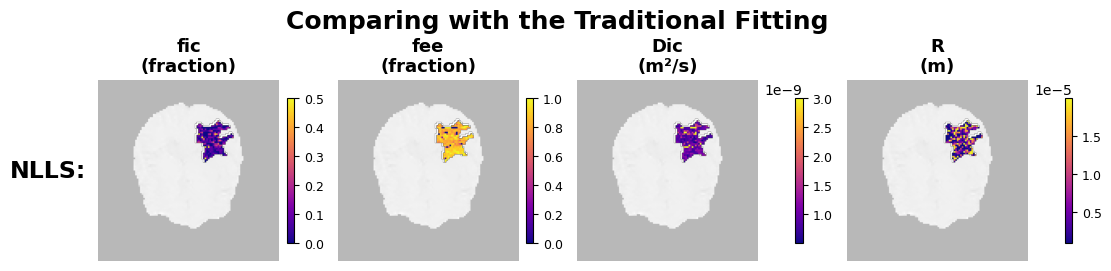


NLLS Parameter Statistics Summary:
Method: Non-Linear Least Squares
Model: AstroSticks-dvZeppelin-Sphere
Patient: Patient05
Central slice: 30
Tumor voxels in slice: 313
fic:  313 voxels | Mean=  0.0826 ±   0.1033
fee:  313 voxels | Mean=  0.8093 ±   0.2037
Dic:  313 voxels | Mean=1.10e-09 ± 5.33e-10
R  :  313 voxels | Mean=7.49e-06 ± 6.88e-06
NLLS parameter map visualization completed.


In [ ]:
# NLLS PARAMETER MAP VISUALIZATION (Multi-Model Comparison Style)
import os, pickle, yaml
import numpy as np
import torch
import matplotlib.pyplot as plt
from functools import lru_cache
from importlib import import_module
from scipy import ndimage
from matplotlib.colors import ListedColormap

print("CREATING NLLS PARAMETER MAP VISUALIZATION (Multi-Model Comparison Style)")
print("=" * 90)

# -----------------------
# Config
# -----------------------
patient_of_interest = 'Patient05'  # NLLS data for Patient 5
print(f"Patient selected for NLLS visualization: {patient_of_interest}")

# NLLS configuration
nlls_spec = {"name": "NLLS:", "method": "Non-Linear Least Squares", "model": "AstroSticks-dvZeppelin-Sphere"}

# parameter names (explicit, consistent with multi-model format)
param_names = ['fic', 'fee', 'Dic', 'R', 'Dpar', 'Dtra', 'theta', 'phi']
compare_params = ['fic', 'fee', 'Dic', 'R']
param_indices = {p: i for i, p in enumerate(param_names)}

print(f"Parameters to visualize: {compare_params}")

# -----------------------
# NLLS Data preparation
# -----------------------
# Load ROI data if not already loaded
try:
    Patient5_roi_data
except NameError:
    Patient5_roi_path = r'D:\AiProjects\UCLmaster\OneDrive_1_2025-5-2\data\Patient05\Patient05_ROIs_to_DWI_small.nii.gz'
    Patient5_roi_img = nib.load(Patient5_roi_path)
    Patient5_roi_data = Patient5_roi_img.get_fdata()
    print("Loaded ROI data")

# Brain data
brain_data_interest = Patient5_data
central_slice = brain_data_interest.shape[2] // 2
brain_slice = brain_data_interest[:, :, central_slice, 0].T
brain_norm = (brain_slice - brain_slice.min()) / (brain_slice.max() - brain_slice.min() + 1e-8)
brain_enhanced = np.power(brain_norm, 0.6)

print(f"Central slice: {central_slice}")
print(f"Brain slice shape: {brain_slice.shape}")

# Find tumor regions
tumor_mask_3d = (Patient5_roi_data == 1) | (Patient5_roi_data == 2)
tumor_voxel_count = np.sum(tumor_mask_3d)
print(f"Total tumor voxels: {tumor_voxel_count}")
print(f"NLLS fitted voxels: {len(fic_values)}")

# Tumor slice data preparation
tumor_slice_mask = tumor_mask_3d[:, :, central_slice].T
tumor_coords_slice = np.where(tumor_slice_mask)

slice_data = {}
if len(tumor_coords_slice[0]) > 0:
    # Get 3D coordinates of all tumor voxels
    tumor_coords_3d = np.where(tumor_mask_3d)
    slice_indices = tumor_coords_3d[2] == central_slice
    n_slice_voxels = np.sum(slice_indices)
    
    if n_slice_voxels > 0:
        print(f"Tumor voxels in central slice: {n_slice_voxels}")
        slice_data['tumor_slice'] = {
            'roi2d': tumor_slice_mask,
            'y': tumor_coords_slice[0][:n_slice_voxels],
            'x': tumor_coords_slice[1][:n_slice_voxels],
            'n_voxels': n_slice_voxels
        }

if not slice_data:
    print("Warning: No tumor voxels found in central slice")

# -----------------------
# NLLS Parameter Maps
# -----------------------
H, W = brain_slice.shape

# Initialize NLLS parameter maps
nlls_param_maps = {p: np.full((H, W), np.nan, dtype=np.float32) for p in compare_params}

# Map NLLS parameters to tumor voxels in the central slice
if slice_data:
    sdata = slice_data['tumor_slice']
    n_voxels = min(sdata['n_voxels'], len(fic_values))
    
    if n_voxels > 0:
        print(f"Mapping {n_voxels} NLLS parameters to central slice")
        
        # Map parameters to slice coordinates
        y, x = sdata['y'][:n_voxels], sdata['x'][:n_voxels]
        
        for p in compare_params:
            param_data = parameters[p][:n_voxels]
            nlls_param_maps[p][y, x] = param_data

# Robust global ranges for Dic and R (consistent with multi-model approach)
def robust_range(param_map, lo=1, hi=99):
    """Return robust vmin/vmax for a parameter map."""
    valid_data = param_map[~np.isnan(param_map)]
    if valid_data.size == 0:
        return (0.0, 1.0)
    lo_v, hi_v = np.nanpercentile(valid_data, [lo, hi])
    if not np.isfinite(lo_v) or not np.isfinite(hi_v) or lo_v == hi_v:
        lo_v, hi_v = float(np.nanmin(valid_data)), float(np.nanmax(valid_data))
    return lo_v, hi_v

dic_vmin, dic_vmax = robust_range(nlls_param_maps['Dic'])
r_vmin, r_vmax = robust_range(nlls_param_maps['R'])
print(f"NLLS Dic range: [{dic_vmin:.2e}, {dic_vmax:.2e}]")
print(f"NLLS R   range: [{r_vmin:.2e}, {r_vmax:.2e}]")

# -----------------------
# Plotting (Multi-Model Comparison Style)
# -----------------------
n_models = 1  # Just NLLS
cols = 1 + len(compare_params)

# Make first column narrow (0.8) and parameter cols wider (2 each)
widths = [0.8] + [2.0] * len(compare_params)

fig, axs = plt.subplots(
    n_models, cols,
    figsize=(2.2 * cols, 2.6 * n_models),
    constrained_layout=True,
    gridspec_kw={"width_ratios": widths}
)

# Ensure 2D array even for single row
if n_models == 1:
    axs = np.expand_dims(axs, 0)

#fig.suptitle(
#    f'NLLS Parameter Maps (Patient {patient_of_interest}, Slice {central_slice})',
#    fontsize=18, fontweight='bold'
#)
fig.suptitle(
    f'Comparing with the Traditional Fitting',
    fontsize=18, fontweight='bold'
)
# Precompute boundary overlay for tumor regions
boundary_overlay = np.zeros_like(brain_slice, dtype=bool)
if slice_data:
    roi2d = slice_data['tumor_slice']['roi2d']
    if np.any(roi2d):
        b = ndimage.binary_dilation(roi2d, structure=np.ones((2,2))) & ~roi2d
        boundary_overlay = b
boundary_mask = np.ma.masked_where(~boundary_overlay, boundary_overlay)

# Single row for NLLS
i = 0
name = nlls_spec['name']

# Model label cell (first column)
ax_label = axs[i, 0]
ax_label.axis('off')
ax_label.text(
    0.5, 0.5, name,
    transform=ax_label.transAxes,
    fontsize=17, fontweight='bold',
    ha='center', va='center'
)

# Parameter maps (remaining columns)
for j, p in enumerate(compare_params, start=1):
    ax = axs[i, j]
    
    # Background brain anatomy
    ax.imshow(brain_enhanced, cmap='gray', vmin=0, vmax=1, alpha=0.28)
    
    # Parameter map
    pm = nlls_param_maps[p]
    
    # Set color range
    if p == 'fee':
        vmin, vmax = 0.0, 1.0
    elif p == 'Dic':
        vmin, vmax = 1.02e-09, 1.65e-09
    elif p == 'fic':
        vmin, vmax = 0.0, 0.5
    else:  # 'R'
        vmin, vmax = r_vmin, r_vmax
    
    # Show parameter map
    im = ax.imshow(np.ma.masked_invalid(pm), cmap='plasma', vmin=vmin, vmax=vmax)
    
    # Overlay tumor boundaries
    if np.any(boundary_overlay):
        ax.imshow(boundary_mask, cmap=ListedColormap(['white']), alpha=0.9)
    
    ax.set_axis_off()
    
    # Parameter title (only for top row)
    if i == 0:
        if p == 'Dic':
            title = f'{p}\n(m²/s)'
        elif p == 'R':
            title = f'{p}\n(m)'
        else:
            title = f'{p}\n(fraction)'
        ax.set_title(title, fontsize=13, fontweight='bold')
    
    # Individual colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.8)
    if p in ('Dic', 'R'):
        cbar.formatter.set_powerlimits((0,0))
        cbar.update_ticks()
    cbar.ax.tick_params(labelsize=9)

plt.show()

# -----------------------
# Summary Statistics
# -----------------------
print(f"\nNLLS Parameter Statistics Summary:")
print("=" * 60)
print(f"Method: {nlls_spec['method']}")
print(f"Model: {nlls_spec['model']}")
print(f"Patient: {patient_of_interest}")
print(f"Central slice: {central_slice}")

if slice_data:
    n_slice_voxels = slice_data['tumor_slice']['n_voxels']
    print(f"Tumor voxels in slice: {n_slice_voxels}")
    
    for p in compare_params:
        valid_data = nlls_param_maps[p][~np.isnan(nlls_param_maps[p])]
        if len(valid_data) > 0:
            mean_val = np.mean(valid_data)
            std_val = np.std(valid_data)
            
            if p in ['Dic', 'R']:
                print(f"{p:3s}: {len(valid_data):4d} voxels | Mean={mean_val:8.2e} ± {std_val:8.2e}")
            else:
                print(f"{p:3s}: {len(valid_data):4d} voxels | Mean={mean_val:8.4f} ± {std_val:8.4f}")
        else:
            print(f"{p:3s}: No valid data in slice")
else:
    print("No tumor voxels found in central slice")

print("NLLS parameter map visualization completed.")